# Model

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score


In [2]:
# Data dummy

np.random.seed(42)

# =========================
# 1. PERIODE BULANAN (5 TAHUN)
# =========================
dates = pd.date_range(start="2020-01-01", end="2024-12-01", freq="MS")
n_months = len(dates)

# =========================
# 2. TREND + SEASONALITY TRAFFIC
# =========================
trend = np.linspace(800, 1300, n_months)  # traffic naik
seasonality = 120 * np.sin(np.arange(n_months) * 2 * np.pi / 12)
noise = np.random.normal(0, 60, n_months)

base_traffic = (trend + seasonality + noise).astype(int)

# =========================
# 3. STORE MAPPING
# =========================
channel_map = {
    "CH01": "Jakarta",
    "CH02": "Bandung",
    "CH03": "Surabaya",
    "CH04": "Medan"
}

store_factor = {
    "Jakarta": 1.2,
    "Bandung": 1.1,
    "Surabaya": 1.0,
    "Medan": 0.9
}

# =========================
# 4. PRODUCT MAPPING
# =========================
product_map = {
    "PR01": "Acne Treatment",
    "PR02": "Facial",
    "PR03": "Skincare A",
    "PR04": "Skincare B"
}

product_factor = {
    "Acne Treatment": 1.3,
    "Facial": 1.2,
    "Skincare A": 1.0,
    "Skincare B": 0.9
}

# =========================
# 5. DOCTOR EFFECT
# =========================
doctor_factor = {
    "D01": 1.0,
    "D02": 1.05,
    "D03": 1.1,
    "D04": 0.95,
    "D05": 1.15
}

# =========================
# 6. GENERATE DATA
# =========================
rows = []

customer_counter = 10000

for i, date in enumerate(dates):

    for ch_code, store in channel_map.items():

        traffic = int(base_traffic[i] * store_factor[store])

        for _ in range(traffic):

            customer_id = customer_counter + np.random.randint(0, 5000)

            gender = np.random.choice(["Male", "Female"])
            age = np.random.randint(18, 60)

            product_code = np.random.choice(list(product_map.keys()))
            product_name = product_map[product_code]

            doctor = np.random.choice(list(doctor_factor.keys()))

            payment = np.random.choice(["Cash", "Card", "Transfer"])

            basket_base = 500000

            basket = (
                basket_base
                * product_factor[product_name]
                * doctor_factor[doctor]
                * np.random.normal(1, 0.05)
            )

            rows.append([
                date,
                ch_code,
                store,
                customer_id,
                gender,
                age,
                store,  # city = store
                product_code,
                product_name,
                doctor,
                "Doctor",
                payment,
                round(basket, 0),
                round(basket, 0)
            ])

data = pd.DataFrame(rows, columns=[
    "Date",
    "ChannelCode",
    "ChannelStoreName",
    "CustomerID",
    "Gender",
    "Age",
    "City",
    "ProductCode",
    "ProductName",
    "DoctorID",
    "MedicalJobdesk",
    "PaymentMethodType",
    "BasketSize",
    "TotalSales"
])

data.head()

,Date,ChannelCode,ChannelStoreName,CustomerID,Gender,Age,City,ProductCode,ProductName,DoctorID,MedicalJobdesk,PaymentMethodType,BasketSize,TotalSales
0,2020-01-01,CH01,Jakarta,13104,Female,40,Jakarta,PR02,Facial,D05,Doctor,Transfer,635692.0,635692.0
1,2020-01-01,CH01,Jakarta,11570,Male,52,Jakarta,PR01,Acne Treatment,D03,Doctor,Cash,737807.0,737807.0
2,2020-01-01,CH01,Jakarta,11028,Female,31,Jakarta,PR03,Skincare A,D03,Doctor,Cash,533091.0,533091.0
3,2020-01-01,CH01,Jakarta,11484,Male,49,Jakarta,PR03,Skincare A,D01,Doctor,Cash,508322.0,508322.0
4,2020-01-01,CH01,Jakarta,14191,Female,47,Jakarta,PR01,Acne Treatment,D05,Doctor,Transfer,718001.0,718001.0


In [3]:
# Pastikan Date dalam format datetime
data["Date"] = pd.to_datetime(data["Date"])

# Buat YearMonth
data["YearMonth"] = data["Date"].dt.to_period("M")

# Agregasi bulanan
monthly = data.groupby("YearMonth").agg({
    "CustomerID": "count",
    "TotalSales": "sum",
    "BasketSize": "mean"
}).reset_index()

monthly.rename(columns={
    "CustomerID": "Traffic",
    "TotalSales": "Revenue",
    "BasketSize": "AvgBasket"
}, inplace=True)

monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()

monthly.head()

,YearMonth,Traffic,Revenue,AvgBasket
0,2020-01-01,3480,2.012899e+09,578419.168966
1,2020-02-01,3612,2.084522e+09,577110.165836
2,2020-03-01,4026,2.321420e+09,576607.001987
3,2020-04-01,4350,2.526456e+09,580794.533103
4,2020-05-01,3875,2.230978e+09,575736.276903


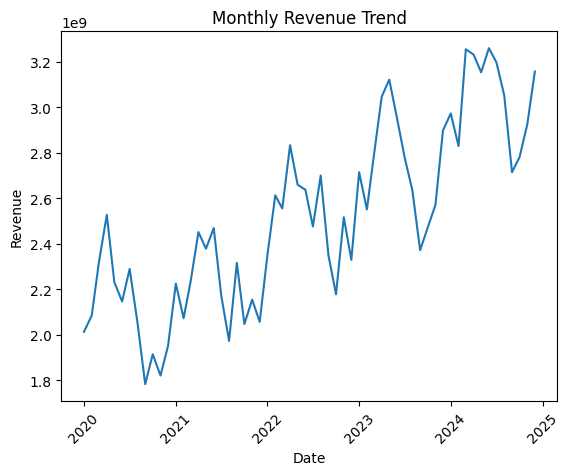

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly["YearMonth"], monthly["Revenue"])
plt.title("Monthly Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

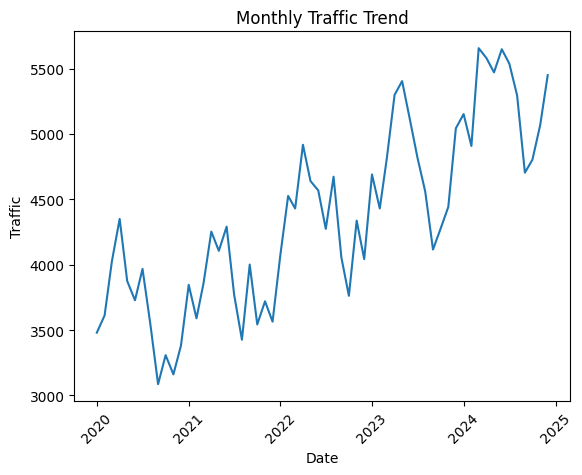

In [5]:
plt.figure()
plt.plot(monthly["YearMonth"], monthly["Traffic"])
plt.title("Monthly Traffic Trend")
plt.xlabel("Date")
plt.ylabel("Traffic")
plt.xticks(rotation=45)
plt.show()

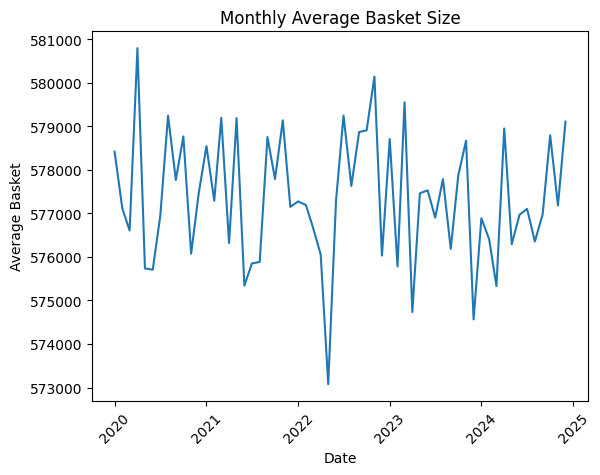

In [6]:
plt.figure()
plt.plot(monthly["YearMonth"], monthly["AvgBasket"])
plt.title("Monthly Average Basket Size")
plt.xlabel("Date")
plt.ylabel("Average Basket")
plt.xticks(rotation=45)
plt.show()

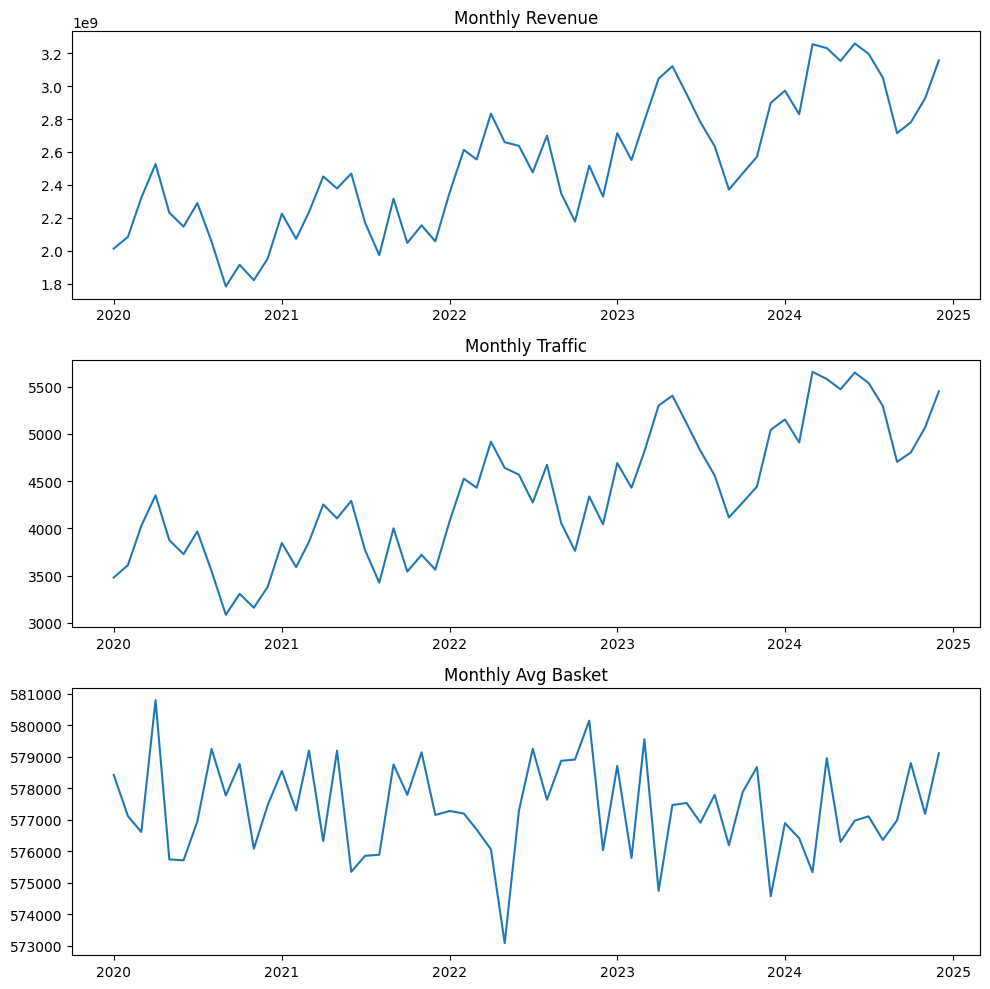

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].plot(monthly["YearMonth"], monthly["Revenue"])
axes[0].set_title("Monthly Revenue")

axes[1].plot(monthly["YearMonth"], monthly["Traffic"])
axes[1].set_title("Monthly Traffic")

axes[2].plot(monthly["YearMonth"], monthly["AvgBasket"])
axes[2].set_title("Monthly Avg Basket")

plt.tight_layout()
plt.show()

🚀 Implikasi untuk Forecasting

Kita harus treat berbeda:

Revenue & Traffic

→ Perlu differencing (karena ada trend)

Basket

→ Bisa langsung model tanpa differencing

### Differencing

In [8]:
monthly = monthly.sort_values("YearMonth")
monthly.set_index("YearMonth", inplace=True)

monthly.head()

,Traffic,Revenue,AvgBasket
YearMonth,,,
2020-01-01,3480,2.012899e+09,578419.168966
2020-02-01,3612,2.084522e+09,577110.165836
2020-03-01,4026,2.321420e+09,576607.001987
2020-04-01,4350,2.526456e+09,580794.533103
2020-05-01,3875,2.230978e+09,575736.276903


In [11]:
monthly["Revenue_diff1"] = monthly["Revenue"].diff()
monthly["Traffic_diff1"] = monthly["Traffic"].diff()

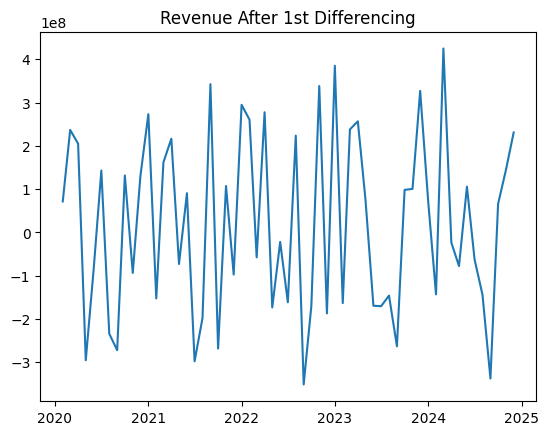

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly["Revenue_diff1"])
plt.title("Revenue After 1st Differencing")
plt.show()

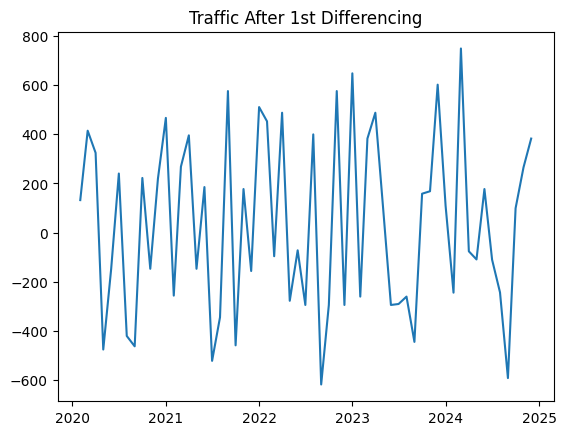

In [13]:
plt.figure()
plt.plot(monthly["Traffic_diff1"])
plt.title("Traffic After 1st Differencing")
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

# Revenue
result_rev = adfuller(monthly["Revenue_diff1"].dropna())
print("Revenue ADF p-value:", result_rev[1])

# Traffic
result_tra = adfuller(monthly["Traffic_diff1"].dropna())
print("Traffic ADF p-value:", result_tra[1])

Revenue ADF p-value: 2.5435033052059703e-09
Traffic ADF p-value: 8.606554067038204e-10


📌 Interpretasi ADF

p-value < 0.05 → sudah stationary

p-value > 0.05 → masih perlu differencing lagi

Karna nilai p-value < 0.05 maka data sudah stasioner



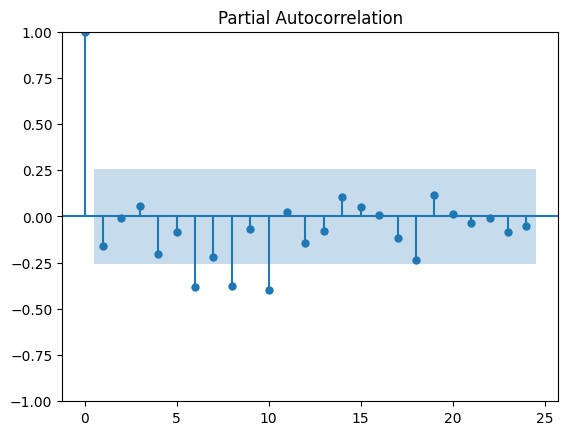

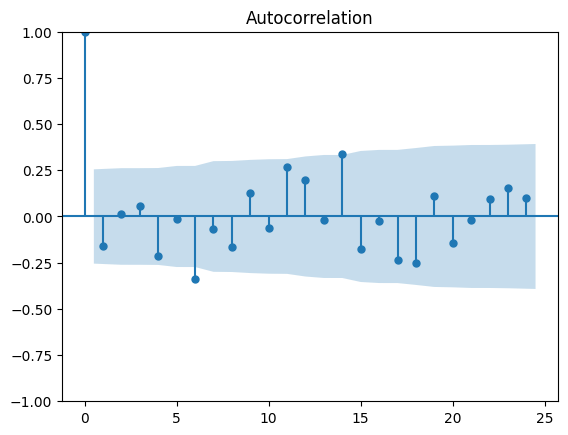

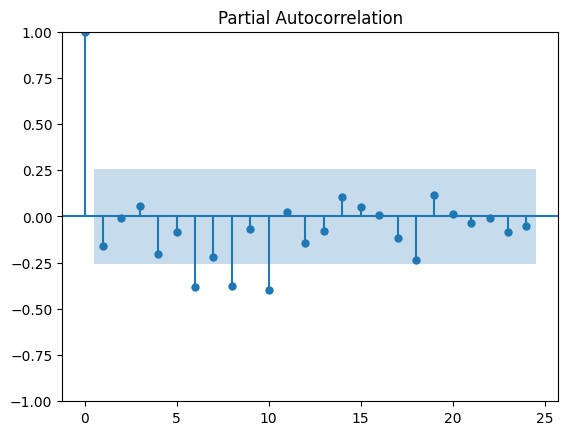

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(monthly["Revenue_diff1"].dropna(), lags=24)
plot_pacf(monthly["Revenue_diff1"].dropna(), lags=24)

### Model SARIMA

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    monthly["Revenue"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

results = model.fit()

print(results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -967.303
Date:                            Tue, 24 Feb 2026   AIC                           1944.606
Time:                                    02:26:18   BIC                           1953.857
Sample:                                01-01-2020   HQIC                          1948.087
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2865      0.590      0.486      0.627      -0.870       1.443
ma.L1         -0.5166      0.551   

In [17]:
forecast = results.get_forecast(steps=6)
forecast_ci = forecast.conf_int()

forecast_values = forecast.predicted_mean

In [18]:
forecast_values

,predicted_mean
2025-01-01,3.482985e+09
2025-02-01,3.416703e+09
2025-03-01,3.658488e+09
2025-04-01,3.760337e+09
2025-05-01,3.680066e+09
2025-06-01,3.699610e+09


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    monthly["Revenue"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

print(results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1724.327
Date:                            Tue, 24 Feb 2026   AIC                           3458.653
Time:                                    02:28:51   BIC                           3466.136
Sample:                                01-01-2020   HQIC                          3461.171
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1269   5.87e+06   2.16e-08      1.000   -1.15e+07    1.15e+07
ma.L1         -0.8637   3.16e+06  -

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


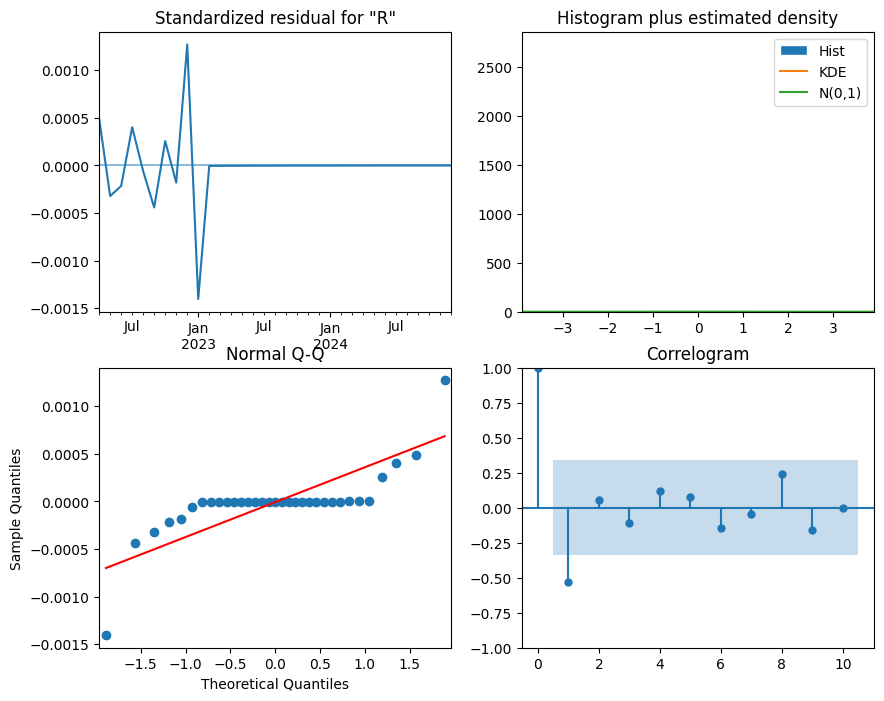

In [20]:
results.plot_diagnostics(figsize=(10,8))
plt.show()

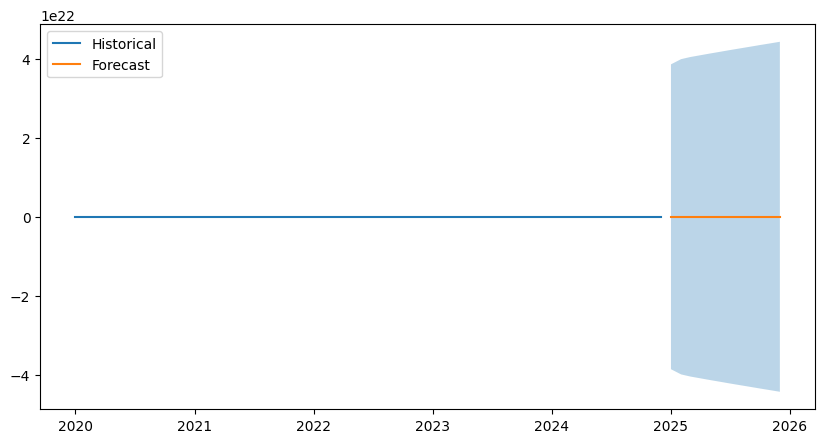

In [21]:
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly["Revenue"], label="Historical")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.3
)
plt.legend()
plt.show()

### Cek Akurasi

In [27]:
# split
train = monthly.loc["2020":"2023"]
test = monthly.loc["2024"]

In [28]:
model = SARIMAX(train["Revenue"], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [29]:
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

In [30]:
import numpy as np
from sklearn.metrics import mean_absolute_error

actual = test["Revenue"]

mae = mean_absolute_error(actual, forecast_mean)
mape = np.mean(np.abs((actual - forecast_mean) / actual)) * 100
accuracy = 100 - mape

print("MAPE:", mape)
print("Accuracy:", accuracy)

MAPE: 11.34317497857037
Accuracy: 88.65682502142963


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# misalnya:
actual = test_data["Revenue"]
predicted = forecast_mean

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

accuracy = 100 - mape

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("Accuracy:", accuracy)

In-sample MAE: 4.2635486775468973e+21
In-sample RMSE: 1.3364515883327924e+22
In-sample MAPE: 188685419158671.44
In-sample Accuracy: -188685419158571.44


### Final Model

In [31]:
forecast = results.get_forecast(steps=6)
forecast_ci = forecast.conf_int()

forecast_values = forecast.predicted_mean
forecast_values

,predicted_mean
2024-01-01,3.359929e+09
2024-02-01,3.311102e+09
2024-03-01,3.438854e+09
2024-04-01,3.643134e+09
2024-05-01,3.584161e+09
2024-06-01,3.520427e+09


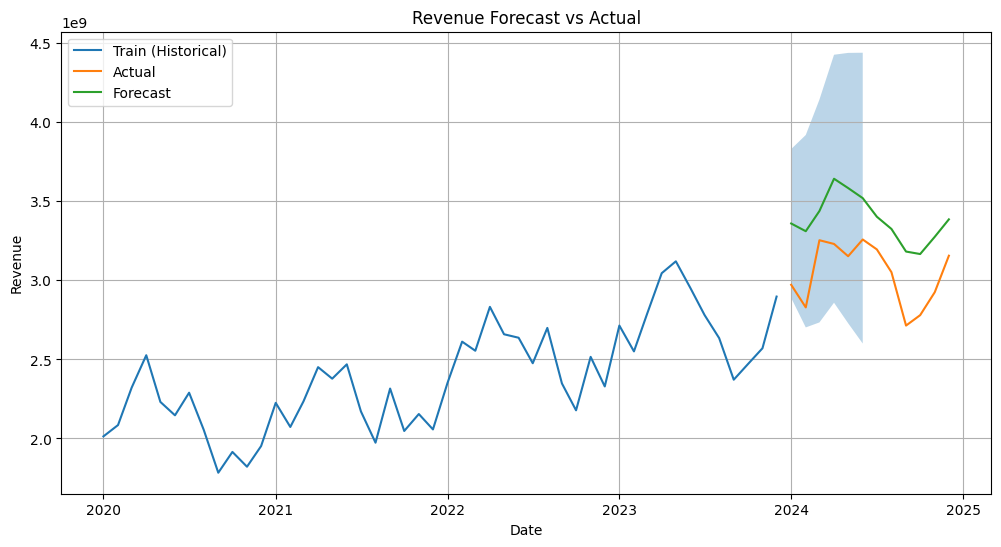

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Historical Train
plt.plot(train.index, train["Revenue"], label="Train (Historical)")

# Actual Test
plt.plot(test.index, test["Revenue"], label="Actual")

# Forecast
plt.plot(forecast_mean.index, forecast_mean, label="Forecast")

# Confidence Interval
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.3
)

plt.title("Revenue Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()

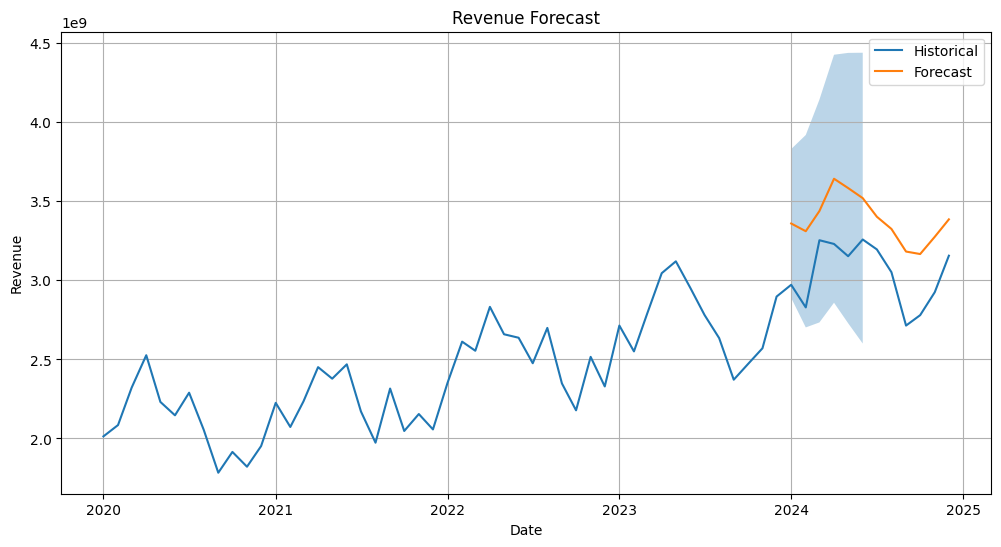

In [34]:
plt.figure(figsize=(12,6))

plt.plot(monthly.index, monthly["Revenue"], label="Historical")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.3
)

plt.title("Revenue Forecast")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train Traffic
model_traffic = SARIMAX(train["Traffic"],
                        order=(1,1,1),
                        seasonal_order=(1,1,1,12))

results_traffic = model_traffic.fit()

forecast_traffic = results_traffic.get_forecast(steps=len(test))
forecast_traffic_mean = forecast_traffic.predicted_mean
forecast_traffic_ci = forecast_traffic.conf_int()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
model_basket = SARIMAX(train["AvgBasket"],
                       order=(1,0,1),
                       seasonal_order=(0,0,0,12))

results_basket = model_basket.fit()

forecast_basket = results_basket.get_forecast(steps=len(test))
forecast_basket_mean = forecast_basket.predicted_mean
forecast_basket_ci = forecast_basket.conf_int()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


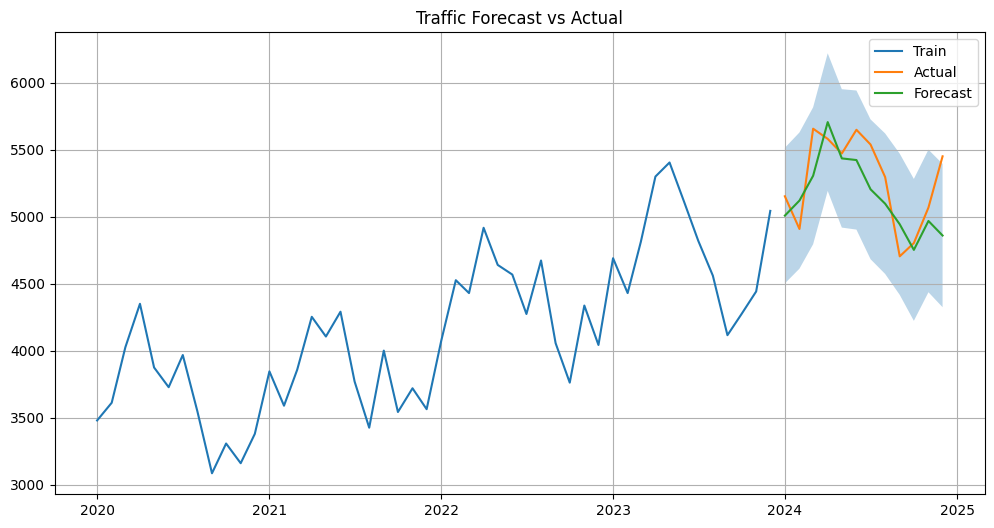

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(train.index, train["Traffic"], label="Train")
plt.plot(test.index, test["Traffic"], label="Actual")
plt.plot(forecast_traffic_mean.index, forecast_traffic_mean, label="Forecast")

plt.fill_between(
    forecast_traffic_ci.index,
    forecast_traffic_ci.iloc[:, 0],
    forecast_traffic_ci.iloc[:, 1],
    alpha=0.3
)

plt.title("Traffic Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

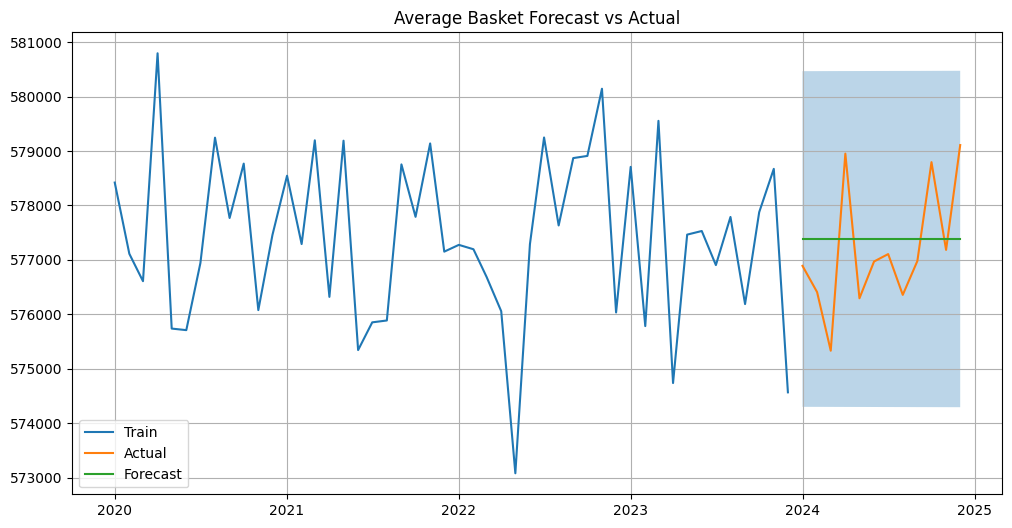

In [38]:
plt.figure(figsize=(12,6))

plt.plot(train.index, train["AvgBasket"], label="Train")
plt.plot(test.index, test["AvgBasket"], label="Actual")
plt.plot(forecast_basket_mean.index, forecast_basket_mean, label="Forecast")

plt.fill_between(
    forecast_basket_ci.index,
    forecast_basket_ci.iloc[:, 0],
    forecast_basket_ci.iloc[:, 1],
    alpha=0.3
)

plt.title("Average Basket Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

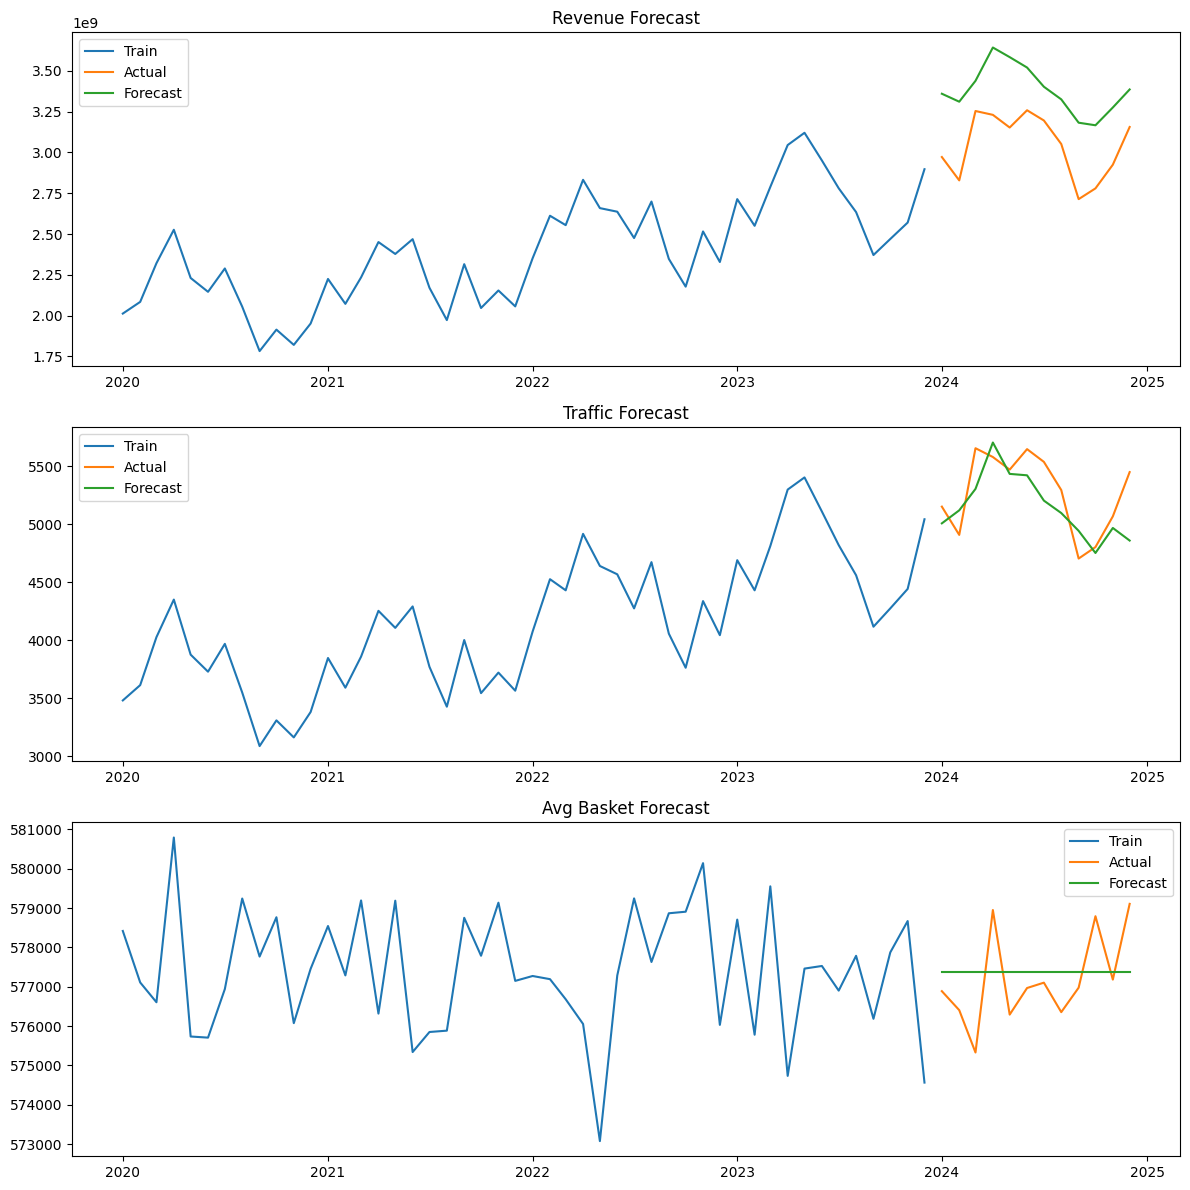

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(12,12))

# Revenue
axes[0].plot(train.index, train["Revenue"], label="Train")
axes[0].plot(test.index, test["Revenue"], label="Actual")
axes[0].plot(forecast_mean.index, forecast_mean, label="Forecast")
axes[0].set_title("Revenue Forecast")
axes[0].legend()

# Traffic
axes[1].plot(train.index, train["Traffic"], label="Train")
axes[1].plot(test.index, test["Traffic"], label="Actual")
axes[1].plot(forecast_traffic_mean.index, forecast_traffic_mean, label="Forecast")
axes[1].set_title("Traffic Forecast")
axes[1].legend()

# Basket
axes[2].plot(train.index, train["AvgBasket"], label="Train")
axes[2].plot(test.index, test["AvgBasket"], label="Actual")
axes[2].plot(forecast_basket_mean.index, forecast_basket_mean, label="Forecast")
axes[2].set_title("Avg Basket Forecast")
axes[2].legend()

plt.tight_layout()
plt.show()